# Calculate seasonal wind trends at all Arctic points

* **Description**: Reads in and creates spatial plots of wind trends
* **Input data**: CESM2-LE and Rufmod output in timeseries format
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: December 2021

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import pop_tools

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.12.206.18:33696' processes=0 threads=0, memory=0 B>

## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'U10'

In [5]:
# Load a Landfrac mask
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/b.e21.BSSP370.f09_g17.rufmod.001.cam.h0.2015-01.nc')
my_mask = ds_masks['LANDFRAC'].isel(time=0)

## Load rufmod experiments

In [6]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/duvivier/arctic_cyclones/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/atm/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/atm/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/atm/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/atm/proc/tseries/month_1/'

In [7]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading U10
CPU times: user 1.2 s, sys: 425 ms, total: 1.63 s
Wall time: 42.1 s


In [8]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

In [9]:
# set member_id values
futures_1.member_id.values

# assign member_id as coordinate array
futures_1.assign_coords({"member_id": futures_1.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [10]:
futures_1

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: member_id, nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [11]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

In [12]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:  time interval endpoints

In [13]:
U10_rufmod = futures_1[var_in_1]

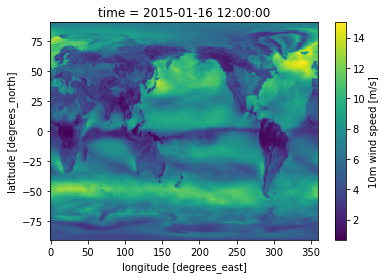

In [14]:
U10_rufmod.sel(member_id=0).isel(time=0).plot()

In [15]:
#mask just NH ocean points
U10_masked_rufmod = U10_rufmod.where((U10_rufmod['lat']>70.0) & (my_mask<0.5), drop=True)

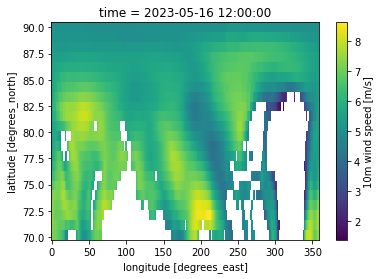

In [16]:
# test simple plot
U10_masked_rufmod.sel(member_id=0).isel(time=100).plot()

In [17]:
U10_masked_rufmod.load()

<xarray.DataArray 'U10' (member_id: 5, time: 1032, lat: 22, lon: 288)>
array([[[[11.06793  , 10.969294 , 10.853632 , ..., 11.531877 ,
          11.292971 , 11.175346 ],
         [10.861583 , 10.791613 , 10.773669 , ..., 12.246518 ,
          11.648091 , 11.174871 ],
         [11.831094 , 11.298049 , 11.004476 , ..., 13.243856 ,
          12.893343 , 12.308632 ],
         ...,
         [ 6.967016 ,  6.9751096,  6.980671 , ...,  6.9373527,
           6.9472327,  6.9564366],
         [ 6.7671547,  6.768988 ,  6.7709785, ...,  6.7615557,
           6.762776 ,  6.764975 ],
         [ 6.579826 ,  6.5804806,  6.581078 , ...,  6.57744  ,
           6.578315 ,  6.579107 ]],

        [[10.475566 , 10.284442 , 10.104487 , ..., 11.960213 ,
          11.352178 , 10.809615 ],
         [10.026171 ,  9.884076 ,  9.815837 , ..., 11.635889 ,
          11.125332 , 10.501084 ],
         [10.18181  ,  9.965411 ,  9.898421 , ..., 11.6331835,
          11.182013 , 10.580417 ],
...
         [ 7.173467 ,  7.195772 ,  7.219115 , ...,  7.1154704,
           7.133872 ,  7.152879 ],
         [ 7.43225  ,  7.4417696,  7.451752 , ...,  7.404404 ,
           7.4133053,  7.4227314],
         [ 7.491217 ,  7.4917884,  7.492311 , ...,  7.489141 ,
           7.4899015,  7.4905906]],

        [[ 8.287982 ,  8.400559 ,  8.480927 , ...,  8.067488 ,
           8.028663 ,  8.15269  ],
         [ 8.009883 ,  8.204998 ,  8.369442 , ...,  7.531934 ,
           7.592892 ,  7.740536 ],
         [ 7.353426 ,  7.651292 ,  7.8322706, ...,  6.8313575,
           6.9246416,  7.1242747],
         ...,
         [ 5.7197413,  5.734756 ,  5.7504964, ...,  5.68984  ,
           5.699203 ,  5.708425 ],
         [ 5.6098113,  5.6146116,  5.6195397, ...,  5.595375 ,
           5.5993805,  5.604605 ],
         [ 5.453021 ,  5.453191 ,  5.453348 , ...,  5.4524117,
           5.4526334,  5.4528356]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 70.21 71.15 72.09 73.04 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [18]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [19]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'
comp = 'atm'
freq = 'month_1'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt, component=comp, frequency=freq )

In [20]:
subset_1

In [21]:
subset_1.df.head()

component  stream                                     case    member_id  \
0       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
1       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
2       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
3       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   
4       atm  cam.h0  b.e21.BSSP370cmip6.f09_g17.LE2-1001.001  r1i1001p1f1   

  variable start_time end_time     time_range       long_name units  \
0      U10    2015-01  2024-12  201501-202412  10m wind speed   m/s   
1      U10    2025-01  2034-12  202501-203412  10m wind speed   m/s   
2      U10    2035-01  2044-12  203501-204412  10m wind speed   m/s   
3      U10    2045-01  2054-12  204501-205412  10m wind speed   m/s   
4      U10    2055-01  2064-12  205501-206412  10m wind speed   m/s   

   vertical_levels frequency  \
0              1.0   month_1   
1              1.0   month_1   
2              1.0   month_1   
3              1.0   month_1   
4              1.0   month_1   

                                                path experiment  \
0  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
1  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
2  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
3  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   
4  /glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...     ssp370   

  forcing_variant  cesm_member_id  control_branch_year  \
0           cmip6        1001.001                 1001   
1           cmip6        1001.001                 1001   
2           cmip6        1001.001                 1001   
3           cmip6        1001.001                 1001   
4           cmip6        1001.001                 1001   

         cmip_experiment_id  
0  CESM2_ssp370_r1i1001p1f1  
1  CESM2_ssp370_r1i1001p1f1  
2  CESM2_ssp370_r1i1001p1f1  
3  CESM2_ssp370_r1i1001p1f1  
4  CESM2_ssp370_r1i1001p1f1

In [22]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.experiment.unique())
print(member_id)

['ssp370']


In [23]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.78 s, sys: 174 ms, total: 6.96 s
Wall time: 16 s


In [24]:
# load in the future datasets
futures_1 = []
for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)
    

atm.ssp370.cam.h0.cmip6.U10


In [25]:
future_ds_1 = xr.concat(futures_1, dim='member_id')

In [26]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [27]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bnds.load().mean(dim='nbnd').sel(member_id='r1i1281p1f1')

In [28]:
U10_le = future_ds_1[var_in_1]

In [29]:
U10_le.persist()

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(50, 1032, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

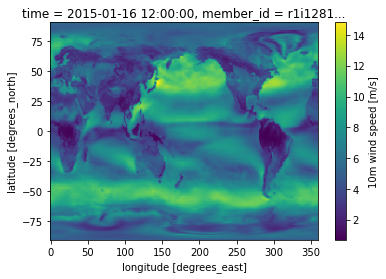

In [30]:
U10_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [31]:
U10_le

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 192, lon: 288)>
dask.array<concatenate, shape=(50, 1032, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

In [32]:
# set mask lat/lon to equal those from LE, otherwise masking below doesn't work properly
my_mask['lat'] = U10_le['lat']
my_mask['lon'] = U10_le['lon']

In [33]:
#mask just NH ocean points
U10_masked_le = U10_le.where((U10_le['lat']>70.0) & (my_mask<0.5), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


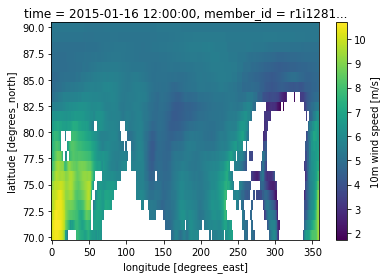

In [34]:
# test simple plot
U10_masked_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

In [35]:
U10_masked_le

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 22, lon: 288)>
dask.array<where, shape=(50, 1032, 22, 288), dtype=float32, chunksize=(1, 120, 22, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 70.21 71.15 72.09 73.04 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

In [36]:
#U10_masked_le.persist()
U10_masked_le.load()

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 22, lon: 288)>
array([[[[10.87047  , 10.828375 , 10.820683 , ..., 11.009366 ,
          10.995667 , 10.955311 ],
         [10.520812 , 10.551184 , 10.596888 , ..., 10.772621 ,
          10.699037 , 10.57545  ],
         [10.455039 , 10.55242  , 10.607426 , ..., 10.518526 ,
          10.426251 , 10.392168 ],
         ...,
         [ 5.78851  ,  5.778726 ,  5.768209 , ...,  5.810846 ,
           5.8038464,  5.796437 ],
         [ 5.7001243,  5.693169 ,  5.6854906, ...,  5.7161965,
           5.7128196,  5.706865 ],
         [ 5.5398855,  5.540644 ,  5.541333 , ...,  5.5371037,
           5.5381265,  5.5390496]],

        [[ 8.922403 ,  9.006664 ,  9.005695 , ...,  8.673686 ,
           8.762959 ,  8.849436 ],
         [ 8.648395 ,  8.807054 ,  8.922185 , ...,  8.345491 ,
           8.382178 ,  8.454087 ],
         [ 8.337257 ,  8.498895 ,  8.590935 , ...,  8.192364 ,
           8.172587 ,  8.215044 ],
...
         [ 7.9523544,  7.964251 ,  7.975963 , ...,  7.9179864,
           7.9292803,  7.940444 ],
         [ 8.024183 ,  8.028629 ,  8.033385 , ...,  8.011083 ,
           8.01542  ,  8.019788 ],
         [ 8.11938  ,  8.119451 ,  8.119516 , ...,  8.11913  ,
           8.119221 ,  8.119304 ]],

        [[11.030194 , 11.120283 , 11.176671 , ..., 10.590443 ,
          10.781649 , 10.943008 ],
         [10.595212 , 10.681006 , 10.784918 , ..., 10.092263 ,
          10.29651  , 10.441756 ],
         [10.012612 , 10.1496525, 10.217468 , ...,  9.629392 ,
           9.739168 ,  9.8990965],
         ...,
         [ 5.3721595,  5.375409 ,  5.378751 , ...,  5.357165 ,
           5.362349 ,  5.367639 ],
         [ 5.4360347,  5.440225 ,  5.444049 , ...,  5.4261785,
           5.4272623,  5.431425 ],
         [ 5.134293 ,  5.1355476,  5.136693 , ...,  5.1297193,
           5.1313963,  5.1329145]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 70.21 71.15 72.09 73.04 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

## Calculate seasonal means

In [37]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [38]:
# calculate seasonal indexes  - DIDN'T END UP DOING IT THIS WAY, DID IT MANUALLY FOR GROUPINGS ABOVE
#season_names = ['DJF', 'MAM', 'JJA', 'SON']
#season_idxs_le = sidragtop_masked_le.groupby('time.season').groups
#season_idxs_rufmod = sidragtop_masked_rufmod.groupby('time.season').groups

In [39]:
# find total years
xarr_le = U10_masked_le.coords['time.year'][(U10_masked_le.coords['time.month']==1)]
xarr_rufmod = U10_masked_rufmod.coords['time.year'][(U10_masked_rufmod.coords['time.month']==1)]

In [40]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(U10_masked_rufmod.member_id),len(U10_masked_rufmod.lat),len(U10_masked_rufmod.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = U10_masked_rufmod.isel(time=U10_masked_rufmod.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_rufmod[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS


In [41]:
# Loop through seasons - CESM2-LE

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(U10_masked_le.member_id),len(U10_masked_le.lat),len(U10_masked_le.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = U10_masked_le.isel(time=U10_masked_le.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_le[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS


In [42]:
print(seas_array_le.shape)
print(seas_array_rufmod.shape)

(4, 86, 50, 22, 288)
(4, 86, 5, 22, 288)


In [43]:
U10_masked_le

<xarray.DataArray 'U10' (member_id: 50, time: 1032, lat: 22, lon: 288)>
array([[[[10.87047  , 10.828375 , 10.820683 , ..., 11.009366 ,
          10.995667 , 10.955311 ],
         [10.520812 , 10.551184 , 10.596888 , ..., 10.772621 ,
          10.699037 , 10.57545  ],
         [10.455039 , 10.55242  , 10.607426 , ..., 10.518526 ,
          10.426251 , 10.392168 ],
         ...,
         [ 5.78851  ,  5.778726 ,  5.768209 , ...,  5.810846 ,
           5.8038464,  5.796437 ],
         [ 5.7001243,  5.693169 ,  5.6854906, ...,  5.7161965,
           5.7128196,  5.706865 ],
         [ 5.5398855,  5.540644 ,  5.541333 , ...,  5.5371037,
           5.5381265,  5.5390496]],

        [[ 8.922403 ,  9.006664 ,  9.005695 , ...,  8.673686 ,
           8.762959 ,  8.849436 ],
         [ 8.648395 ,  8.807054 ,  8.922185 , ...,  8.345491 ,
           8.382178 ,  8.454087 ],
         [ 8.337257 ,  8.498895 ,  8.590935 , ...,  8.192364 ,
           8.172587 ,  8.215044 ],
...
         [ 7.9523544,  7.964251 ,  7.975963 , ...,  7.9179864,
           7.9292803,  7.940444 ],
         [ 8.024183 ,  8.028629 ,  8.033385 , ...,  8.011083 ,
           8.01542  ,  8.019788 ],
         [ 8.11938  ,  8.119451 ,  8.119516 , ...,  8.11913  ,
           8.119221 ,  8.119304 ]],

        [[11.030194 , 11.120283 , 11.176671 , ..., 10.590443 ,
          10.781649 , 10.943008 ],
         [10.595212 , 10.681006 , 10.784918 , ..., 10.092263 ,
          10.29651  , 10.441756 ],
         [10.012612 , 10.1496525, 10.217468 , ...,  9.629392 ,
           9.739168 ,  9.8990965],
         ...,
         [ 5.3721595,  5.375409 ,  5.378751 , ...,  5.357165 ,
           5.362349 ,  5.367639 ],
         [ 5.4360347,  5.440225 ,  5.444049 , ...,  5.4261785,
           5.4272623,  5.431425 ],
         [ 5.134293 ,  5.1355476,  5.136693 , ...,  5.1297193,
           5.1313963,  5.1329145]]]], dtype=float32)
Coordinates:
  * lat        (lat) float64 70.21 71.15 72.09 73.04 ... 87.17 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    units:         m/s
    long_name:     10m wind speed
    cell_methods:  time: mean

In [44]:
# convert the numpy array to a xarray for easier plotting
U10_seas_le = xr.DataArray(seas_array_le,dims=('season','time','member_id','lat','lon'))
U10_seas_rufmod = xr.DataArray(seas_array_rufmod,dims=('season','time','member_id','lat','lon'))

In [45]:
# set coordinate arrays
U10_seas_le['season'] = season_names
U10_seas_le['time'] = xarr_le
U10_seas_le['member_id'] = U10_masked_le['member_id']
U10_seas_le['lat'] = U10_masked_le['lat'].values
U10_seas_le['lon'] = U10_masked_le['lon'].values

U10_seas_rufmod['season'] = season_names
U10_seas_rufmod['time'] = xarr_rufmod
U10_seas_rufmod['member_id'] = U10_masked_rufmod['member_id']
U10_seas_rufmod['lat'] = U10_masked_rufmod['lat'].values
U10_seas_rufmod['lon'] = U10_masked_rufmod['lon'].values

## Calculate and plot ensemble mean

In [46]:
# Calculate ensemble means
U10_seas_ens_mean_le = U10_seas_le.mean(dim='member_id')
U10_seas_ens_mean_rufmod = U10_seas_rufmod.mean(dim='member_id')

#### Plot ensemble means for first 5 years only

In [47]:
# calculate mean state for first 5 years only
# Seasonal and 2015-2019 only to show "initial" difference in winds

yy_st = 2015
yy_ed = 2020
yy = list(range(yy_st,yy_ed,1))

In [48]:
avg_le = U10_seas_ens_mean_le.isel(time=U10_seas_ens_mean_le.time.isin([yy])).mean(dim='time')
avg_rufmod = U10_seas_ens_mean_rufmod.isel(time=U10_seas_ens_mean_rufmod.time.isin([yy])).mean(dim='time')
#avg_rufmod = U10_seas_ens_mean_rufmod.isel(time=[0,1,2,3,4]).mean(dim='time')

In [49]:
# assign lat/lon again so we don't get a weird difference
avg_rufmod['lat'] = avg_le.lat.values
avg_rufmod['lon'] = avg_le.lon.values

diff = avg_rufmod - avg_le

In [50]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [51]:
# set some info for output
longname = U10_masked_le.long_name
units = U10_masked_le.units

In [52]:
# add cyclic points
avg_le = gvutil.xr_add_cyclic_longitudes(avg_le,"lon")
avg_rufmod = gvutil.xr_add_cyclic_longitudes(avg_rufmod,"lon")
diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")

Plotting spatial means for OND
Plotting spatial means for JFM
Plotting spatial means for AMJ
Plotting spatial means for JAS


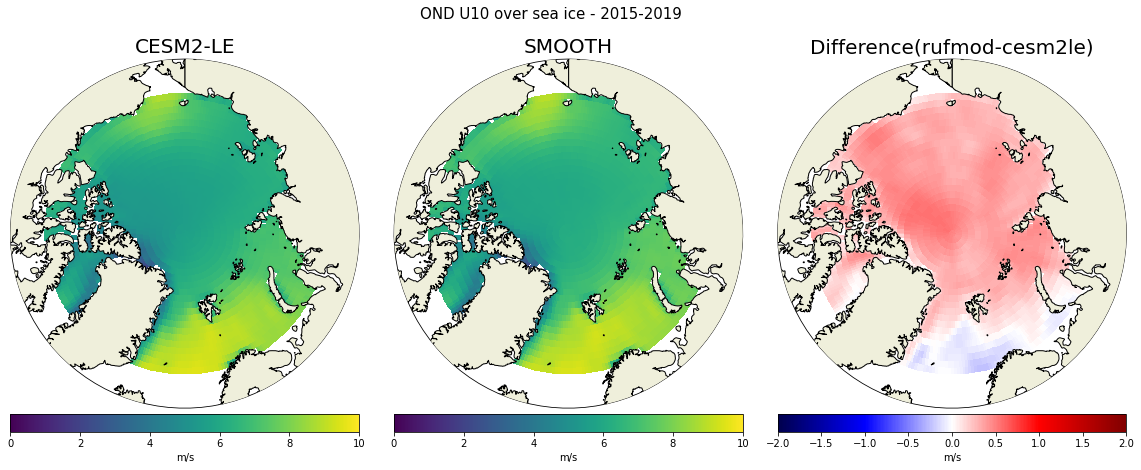

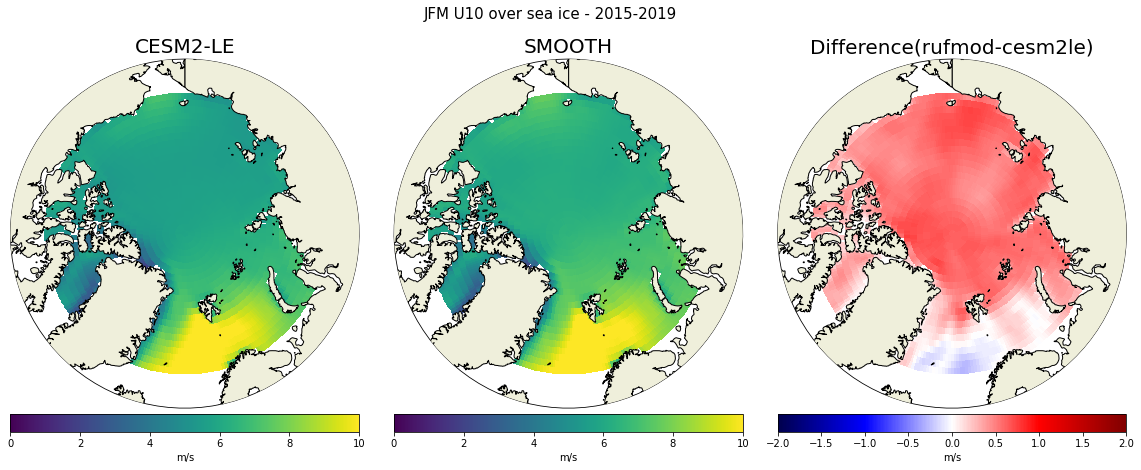

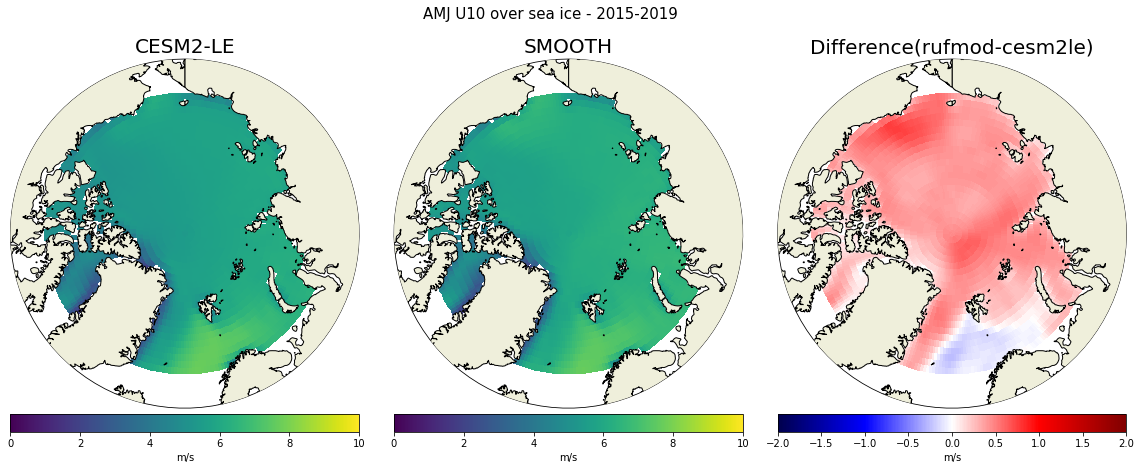

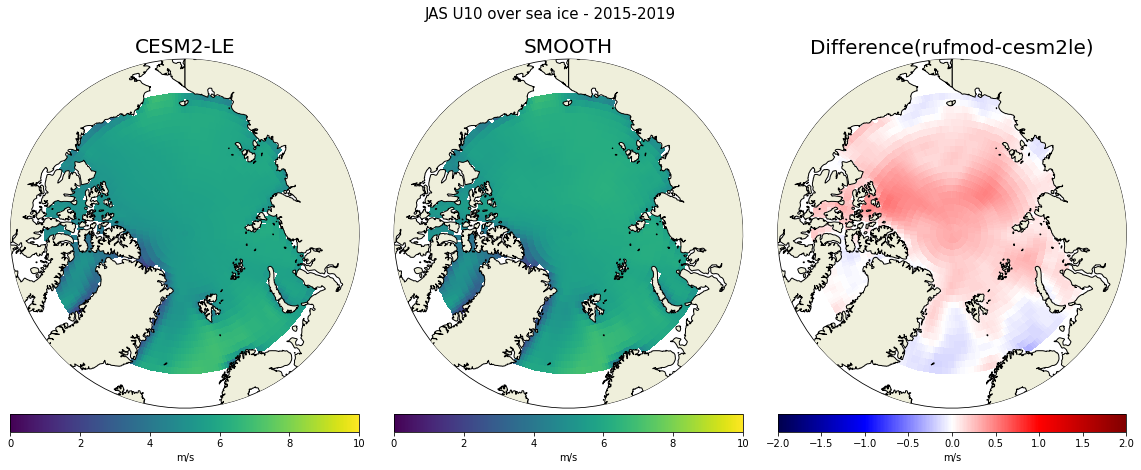

In [53]:
#Plot each season and difference
vmax_in = 10
vmin_in = 0
cmap_in = plt.cm.get_cmap('viridis')
vmax_diff = 2
vmin_diff = -2
cmap_diff = plt.cm.get_cmap('seismic')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Plotting spatial means for '+ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1
    #print(count)
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_difference_2015-2019_'+ss
    title = ss+' U10 over sea ice - 2015-2019'
    
    # grab data we want to plot and add cyclic point
    temp_le = avg_le[count,:,:]
    temp_rufmod = avg_rufmod[count,:,:]
    temp_diff = diff[count,:,:]    

    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(temp_le.lon,temp_le.lat,
                       temp_le,
                       cmap=cmap_in,vmax=vmax_in,vmin=vmin_in,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='horizontal',label=units,fraction=0.04,pad=0.01)
    plt.title('CESM2-LE',fontsize=20)
    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(temp_rufmod.lon,temp_rufmod.lat,
                       temp_rufmod,
                       cmap=cmap_in,vmax=vmax_in,vmin=vmin_in,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='horizontal',label=units,fraction=0.04,pad=0.01)
    plt.title('SMOOTH',fontsize=20)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.pcolormesh(temp_le.lon,temp_le.lat,
                       temp_diff,
                       cmap=cmap_diff,vmax=vmax_diff,vmin=vmin_diff,
                       transform=ccrs.PlateCarree())
    plt.colorbar(this,orientation='horizontal',label=units,fraction=0.04,pad=0.01)
    plt.title('Difference(rufmod-cesm2le)',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)    

#### Now calculate the linear trend at each point

* Want array like this: slope_rufmod = 4(nseas)x22(nlat)x288(nlon)
* Keep slope, r2, and pvalues --> Use pvalue for stippling
* Then plot spatial plots by season of the trends at each point and difference.

In [54]:
# define some functions from Liz Maroon
# These allow us to do a linear regression at all points

def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    slope=((x_an)*(y-y.mean(dname))).sum(dname)/((x_an)*(x_an)).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc  
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):  
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*\
                  (((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope


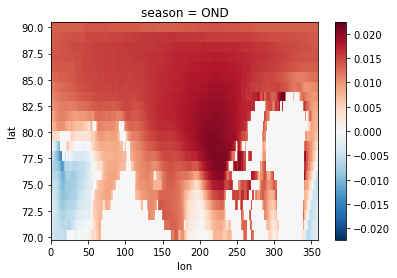

In [55]:
# test this with Liz's functions
tseries = xarr_le
# grab first season only
spatial = U10_seas_ens_mean_le[0,:,:,:]
# set time coordinate arrays to be equal
tseries['time'] = spatial.time
# calculate stats
regcoeff=regcoeff_array(tseries,spatial,'time')
rvalues=rvalue_array(tseries,spatial,'time')
pvalues=pvalue_array(tseries,spatial,'time')
# plot return
regcoeff.plot()

Calculating regressions for OND
Calculating regressions for JFM
Calculating regressions for AMJ
Calculating regressions for JAS


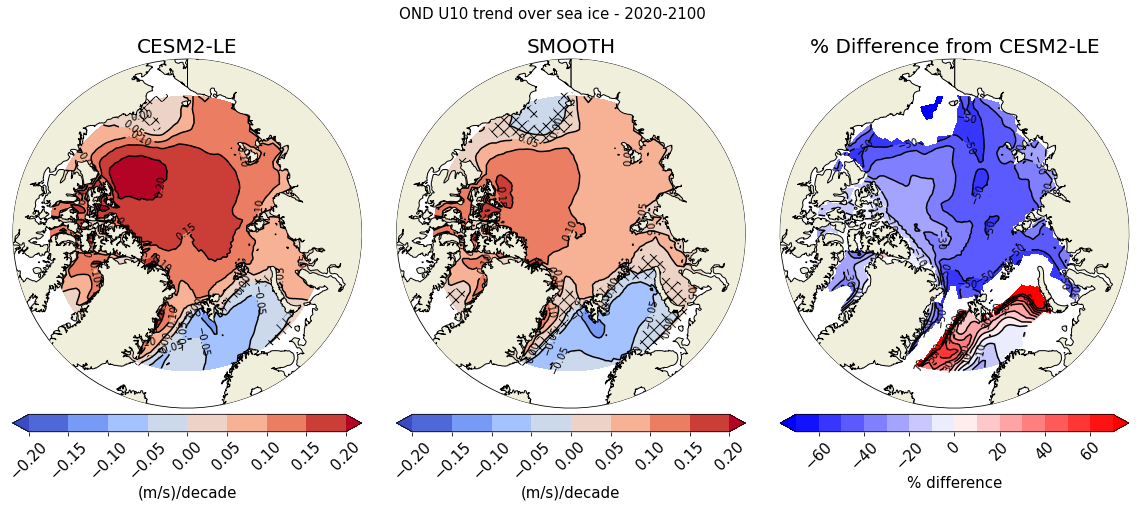

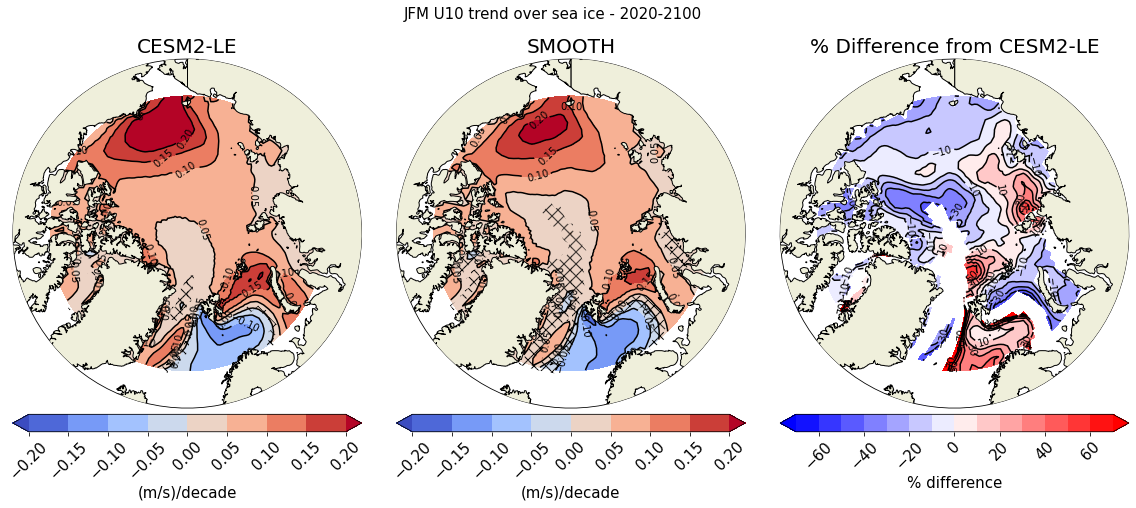

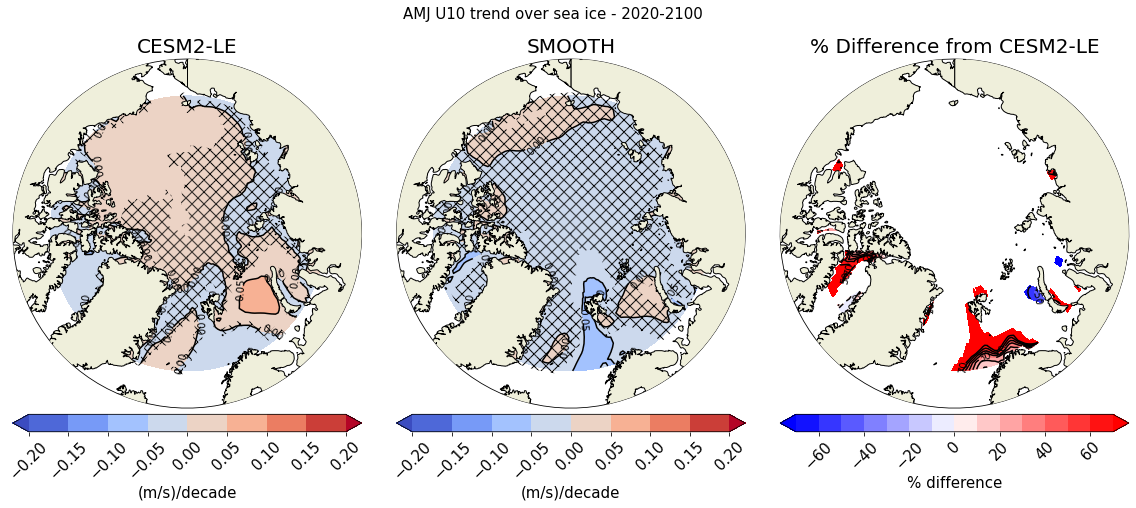

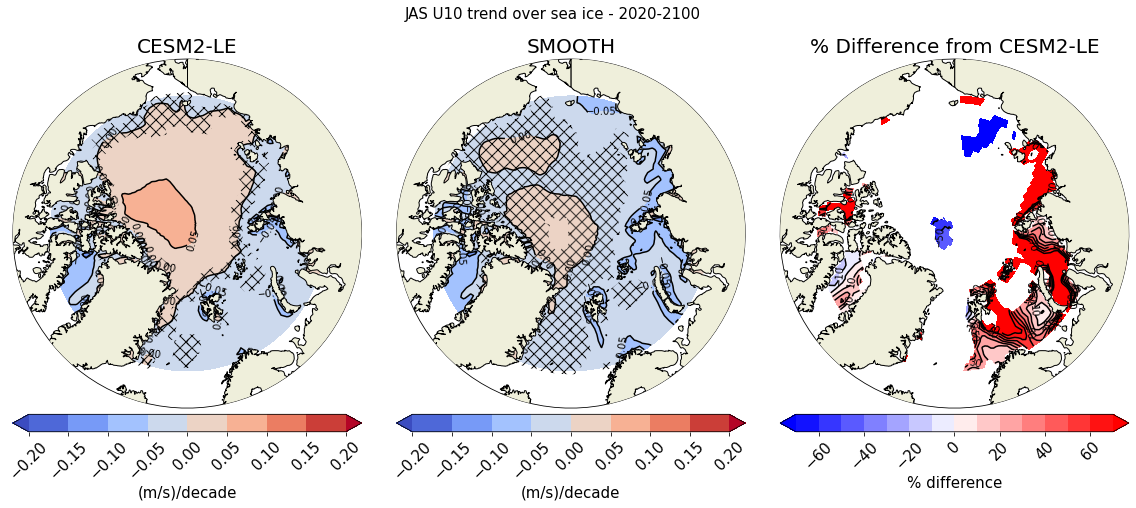

In [58]:
# Loop through the seasons to calculate regressions for full period
ind_st = 5
ind_ed = 85

# set units
units = '(m/s)'

# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.01

#Plot each season and percent difference
levels_in = np.arange(-0.2,0.25,0.05)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-70,80,10)
cmap_diff = plt.cm.get_cmap('bwr')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Calculating regressions for '+ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1
    #print(count)

    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial_le = U10_seas_ens_mean_le[count,ind_st:ind_ed,:,:]
    spatial_rufmod = U10_seas_ens_mean_rufmod[count,ind_st:ind_ed,:,:]
    # set time coordinate arrays to be equal
    spatial_rufmod['time'] = spatial_le.time
    tseries['time'] = spatial_le.time

    # Calculate CESM2-LE regressions (and convert to by decade)
    regcoeff_le=10*regcoeff_array(tseries,spatial_le,'time')
    rvalues_le=rvalue_array(tseries,spatial_le,'time')
    pvalues_le=pvalue_array(tseries,spatial_le,'time')
    regcoeff_le_masked = regcoeff_le.where(pvalues_le < sigval)

    # Calculate rufmod regressions
    regcoeff_rufmod=10*regcoeff_array(tseries,spatial_rufmod,'time')
    rvalues_rufmod=rvalue_array(tseries,spatial_rufmod,'time')
    pvalues_rufmod=pvalue_array(tseries,spatial_rufmod,'time')
    regcoeff_rufmod_masked = regcoeff_rufmod.where(pvalues_rufmod < sigval)

    # calculate difference - need to also set coordinates to be equal
    regcoeff_rufmod_masked['lat'] = regcoeff_le_masked.lat.values
    regcoeff_rufmod_masked['lon'] = regcoeff_le_masked.lon.values
    diff = 100*((regcoeff_rufmod - regcoeff_le)/regcoeff_le)
    diff = 100*((regcoeff_rufmod_masked - regcoeff_le_masked)/regcoeff_le_masked)
        
    # add cyclic point
    regcoeff_le = gvutil.xr_add_cyclic_longitudes(regcoeff_le,"lon")
    regcoeff_le_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_le_masked,"lon")
    regcoeff_rufmod = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod,"lon")    
    regcoeff_rufmod_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod_masked,"lon")
    pvalues_le = gvutil.xr_add_cyclic_longitudes(pvalues_le,"lon")
    pvalues_rufmod = gvutil.xr_add_cyclic_longitudes(pvalues_rufmod,"lon") 
    diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")
    
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_trends_2020_2100_'+ss
    title = ss+' U10 trend over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_le.lon,regcoeff_le.lat,
                       regcoeff_le,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_le.lon,regcoeff_le.lat,
                       regcoeff_le,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_le.lon,pvalues_le.lat,
                       pvalues_le.where(pvalues_le > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('CESM2-LE',fontsize=20)

    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       colors='black',linestyles='solid',levels=levels_in,
                       transform=ccrs.PlateCarree())
    plt.gca().clabel(this2,this2.levels, inline=True, fontsize=10, colors='black')
    # add significance overlay
    sig = ax.pcolor(pvalues_rufmod.lon,pvalues_rufmod.lat,
                       pvalues_rufmod.where(pvalues_rufmod > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('SMOOTH',fontsize=20)
    
    # Third subplot: %difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    # add contour lines and labels
    this2=ax.contour(diff.lon,diff.lat,
                       diff,
                       colors='black',linestyles='solid',levels=levels_diff,
                       transform=ccrs.PlateCarree())    
    plt.gca().clabel(this2,this2.levels[::2], inline=True, fontsize=10, colors='black') 
    #print(this2.levels[::2]) # or [3:14] or [2::2]
    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('% difference', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
    

Calculating regressions for OND
Calculating regressions for JFM
Calculating regressions for AMJ
Calculating regressions for JAS


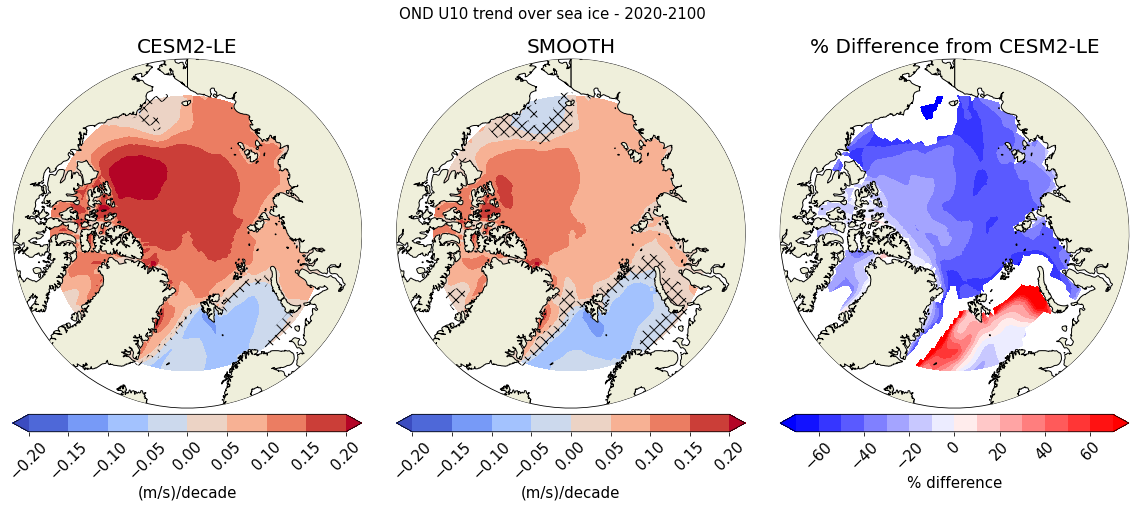

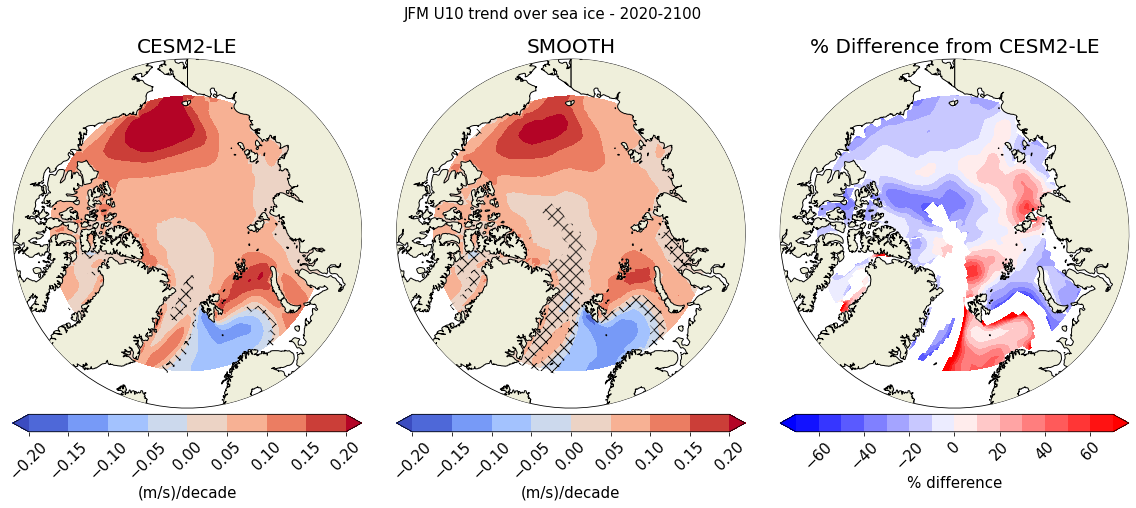

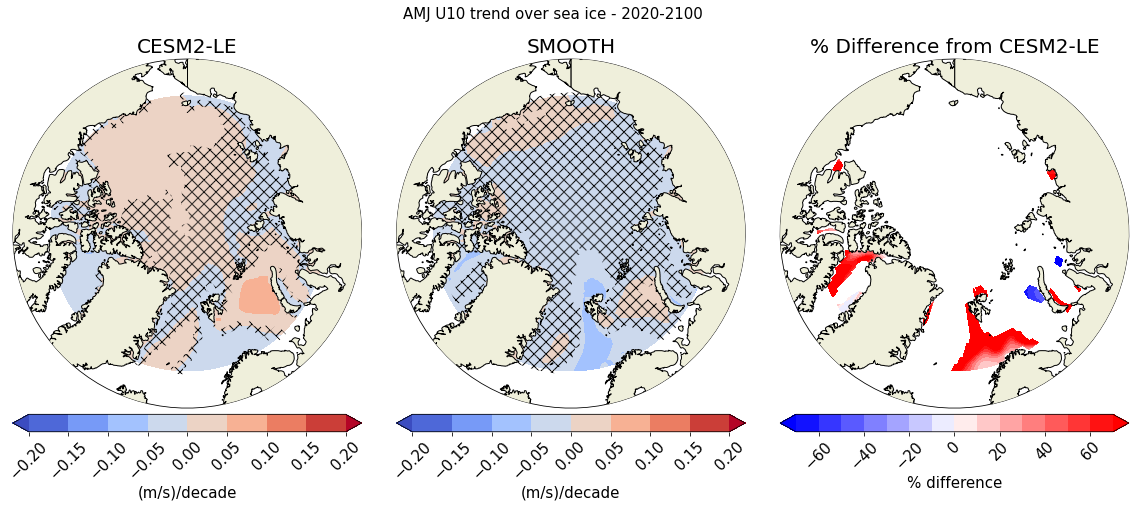

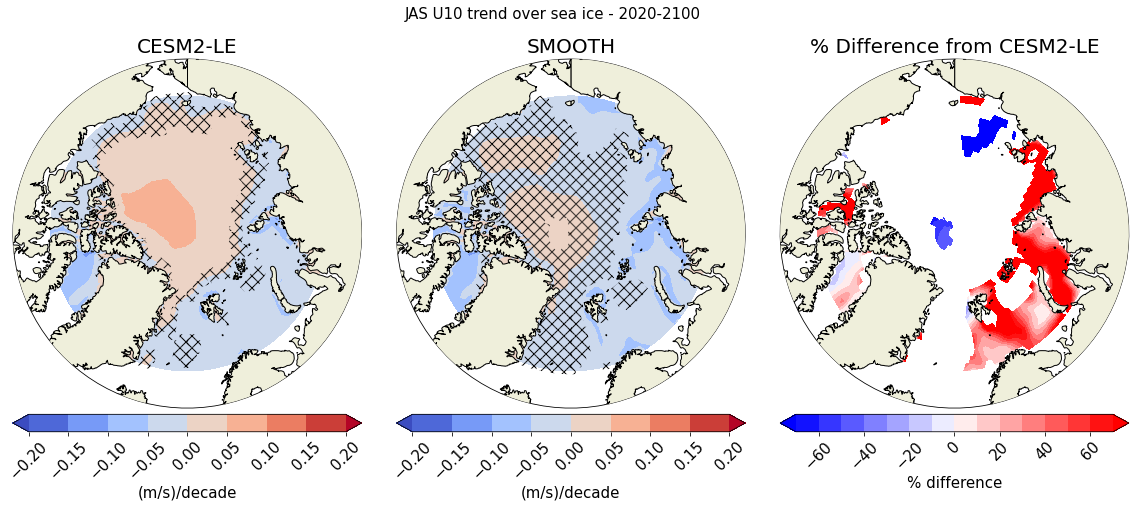

In [59]:
# Loop through the seasons to calculate regressions for full period
ind_st = 5
ind_ed = 85

# set units
units = '(m/s)'

# set significance level (0.05 --> 95%; 0.01 --> 99%)
sigval = 0.01

#Plot each season and percent difference
levels_in = np.arange(-0.2,0.25,0.05)
cmap_in = plt.cm.get_cmap('coolwarm')
levels_diff = np.arange(-70,80,10)
#levels_diff = np.arange(-100,110,10)
cmap_diff = plt.cm.get_cmap('bwr')

#for ss in season_names[0:1]:
for ss in season_names:
    print('Calculating regressions for '+ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1
    #print(count)

    # grab data we want to regress
    tseries = xarr_le[ind_st:ind_ed]
    spatial_le = U10_seas_ens_mean_le[count,ind_st:ind_ed,:,:]
    spatial_rufmod = U10_seas_ens_mean_rufmod[count,ind_st:ind_ed,:,:]
    # set time coordinate arrays to be equal
    spatial_rufmod['time'] = spatial_le.time
    tseries['time'] = spatial_le.time

    # Calculate CESM2-LE regressions (and convert to by decade)
    regcoeff_le=10*regcoeff_array(tseries,spatial_le,'time')
    rvalues_le=rvalue_array(tseries,spatial_le,'time')
    pvalues_le=pvalue_array(tseries,spatial_le,'time')
    regcoeff_le_masked = regcoeff_le.where(pvalues_le < sigval)

    # Calculate rufmod regressions
    regcoeff_rufmod=10*regcoeff_array(tseries,spatial_rufmod,'time')
    rvalues_rufmod=rvalue_array(tseries,spatial_rufmod,'time')
    pvalues_rufmod=pvalue_array(tseries,spatial_rufmod,'time')
    regcoeff_rufmod_masked = regcoeff_rufmod.where(pvalues_rufmod < sigval)

    # calculate difference - need to also set coordinates to be equal
    regcoeff_rufmod_masked['lat'] = regcoeff_le_masked.lat.values
    regcoeff_rufmod_masked['lon'] = regcoeff_le_masked.lon.values
    diff = 100*((regcoeff_rufmod - regcoeff_le)/regcoeff_le)
    diff = 100*((regcoeff_rufmod_masked - regcoeff_le_masked)/regcoeff_le_masked)
        
    # add cyclic point
    regcoeff_le = gvutil.xr_add_cyclic_longitudes(regcoeff_le,"lon")
    regcoeff_le_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_le_masked,"lon")
    regcoeff_rufmod = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod,"lon")    
    regcoeff_rufmod_masked = gvutil.xr_add_cyclic_longitudes(regcoeff_rufmod_masked,"lon")
    pvalues_le = gvutil.xr_add_cyclic_longitudes(pvalues_le,"lon")
    pvalues_rufmod = gvutil.xr_add_cyclic_longitudes(pvalues_rufmod,"lon") 
    diff = gvutil.xr_add_cyclic_longitudes(diff,"lon")
    
    # create figure
    fig = plt.figure(figsize=(20,20))
    fout = 'cesm2_le_and_rufmod_'+var_in_1+'_trends_2020_2100_'+ss
    title = ss+' U10 trend over sea ice - 2020-2100'
     
    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_le.lon,regcoeff_le.lat,
                       regcoeff_le,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add significance overlay
    sig = ax.pcolor(pvalues_le.lon,pvalues_le.lat,
                       pvalues_le.where(pvalues_le > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('CESM2-LE',fontsize=20)

    # Second subplot: Rufmod aka SMOOTH
    ax = fig.add_subplot(1,3,2, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(regcoeff_rufmod.lon,regcoeff_rufmod.lat,
                       regcoeff_rufmod,
                       cmap=cmap_in,levels=levels_in,extend='both',
                       transform=ccrs.PlateCarree())
    # add significance overlay
    sig = ax.pcolor(pvalues_rufmod.lon,pvalues_rufmod.lat,
                       pvalues_rufmod.where(pvalues_rufmod > sigval),
                       alpha=0, hatch='xx',
                       transform=ccrs.PlateCarree())    
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    plt.title('SMOOTH',fontsize=20)
    
    # Third subplot: %difference
    ax = fig.add_subplot(1,3,3, projection=ccrs.NorthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())
    this=ax.contourf(diff.lon,diff.lat,
                       diff,
                       cmap=cmap_diff,levels=levels_diff,extend='both',
                       transform=ccrs.PlateCarree())
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04,pad=0.01)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('% difference', fontsize=15)
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    fig.subplots_adjust(bottom=0.45,wspace=0.1)
    #fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)  
    